### Quick assessment of hydro-deciduous viability 

In [50]:
from scipy.stats import qmc
import numpy as np

import csv
import xarray as xr
import pandas as pd
import os
import netCDF4 as nc4
import sys
import shutil
from tempfile import TemporaryFile                                                                                                                                 
import argparse                                                                                                                                                                                                                                                                                                       
import tempfile 
import random
import re

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import cm
import matplotlib.colors as mcolors
from matplotlib.colors import Normalize
from matplotlib.colors import BoundaryNorm
import cartopy.crs as ccrs

In [51]:
pftnames = ['broadleaf_evergreen_tropical_tree', 'broadleaf_hydrodecid_tropical_tree', 'c4_grass']
print(len(pftnames))

3


In [52]:
def scpf_to_scls_by_pft(scpf_var, dataset):
    """function to reshape a fates multiplexed size and pft-indexed variable to one indexed by size class and pft
    first argument should be an xarray DataArray that has the FATES SCPF dimension
    second argument should be an xarray Dataset that has the FATES SCLS dimension 
    (possibly the dataset encompassing the dataarray being transformed)
    returns an Xarray DataArray with the size and pft dimensions disentangled"""
    n_scls = len(dataset.fates_levscls)
    ds_out = (scpf_var.rolling(fates_levscpf=n_scls, center=False)
            .construct("fates_levscls")
            .isel(fates_levscpf=slice(n_scls-1, None, n_scls))
            .rename({'fates_levscpf':'fates_levpft'})
            .assign_coords({'fates_levscls':dataset.fates_levscls})
            .assign_coords({'fates_levpft':dataset.fates_levpft}))
    ds_out.attrs['long_name'] = scpf_var.attrs['long_name']
    ds_out.attrs['units'] = scpf_var.attrs['units']
    return(ds_out)

In [53]:
fates = '/pscratch/sd/j/jneedham/elm_runs/tropical_fb/full_fates_tropical_control.E64046ec755-Fef7f7756.2025-05-22/run/full_fates_tropical_control.E64046ec755-Fef7f7756.2025-05-22.1900s.nc'
fates = xr.open_dataset(fates,  decode_times=False)

time = fates.variables['time'] / 365.
cohort_size_bins = fates.variables['fates_levscls'][:]
nsizebins = len(cohort_size_bins)


### Vegetation carbon by pft

In [54]:
vegc_pf = fates.FATES_VEGC_PF.mean(dim='time')
recr_pf = fates.FATES_RECRUITMENT_PF.mean(dim='time')

print(vegc_pf.shape)

(3, 16, 72)


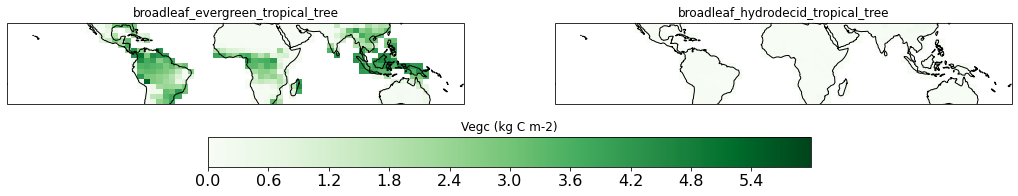

In [55]:
# Define the contour levels to use in plt.contourf
clevs=np.arange(0,6.0,0.01)
fig, axs = plt.subplots(nrows=1,ncols=2,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(18,4))
axs=axs.flatten()
for i in range(0,2):
        cs= vegc_pf.isel(fates_levpft=i).plot(levels=clevs,cmap='Greens', ax=axs[i],add_colorbar=False)
        axs[i].set_title(pftnames[i])
        axs[i].coastlines()

cbar = fig.colorbar(cs, ax=axs, location='bottom',shrink=0.6)
cbar.ax.set_title("Vegc (kg C m-2)")
cbar.ax.tick_params(labelsize=16)


### Hydraulic failure mortality

In [56]:
hmort = scpf_to_scls_by_pft(fates.FATES_MORTALITY_HYDRAULIC_SZPF, fates).sum(dim='fates_levscls')
nplant = scpf_to_scls_by_pft(fates.FATES_NPLANT_SZPF, fates).sum(dim='fates_levscls')

hmort = hmort/nplant
hmort = hmort.mean(dim='time')

print(hmort.shape)

(3, 16, 72)


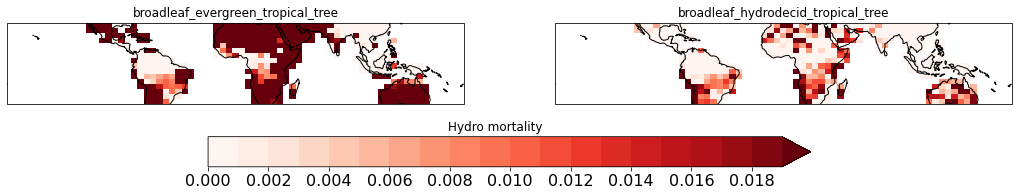

In [57]:
# Define the contour levels to use in plt.contourf
clevs=np.arange(0,0.02,0.001)
fig, axs = plt.subplots(nrows=1,ncols=2,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(18,4))
axs=axs.flatten()
for i in range(0,2):
        cs= hmort.isel(fates_levpft=i).plot(levels=clevs,cmap='Reds', ax=axs[i],add_colorbar=False)
        axs[i].set_title(pftnames[i])
        axs[i].coastlines()

cbar = fig.colorbar(cs, ax=axs, location='bottom',shrink=0.6)
cbar.ax.set_title("Hydro mortality")
cbar.ax.tick_params(labelsize=16)


### C starvation mortality 

In [58]:
cmort = scpf_to_scls_by_pft(fates.FATES_MORTALITY_CSTARV_SZPF, fates).sum(dim='fates_levscls')
nplant = scpf_to_scls_by_pft(fates.FATES_NPLANT_SZPF, fates).sum(dim='fates_levscls')

cmort = cmort/nplant
cmort = cmort.mean(dim='time')

print(cmort.shape)

(3, 16, 72)


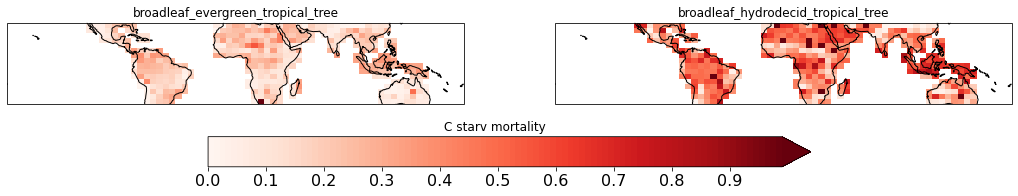

In [59]:
# Define the contour levels to use in plt.contourf
clevs=np.arange(0,1.0,0.01)
fig, axs = plt.subplots(nrows=1,ncols=2,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(18,4))
axs=axs.flatten()
for i in range(0,2):
        cs= cmort.isel(fates_levpft=i).plot(levels=clevs,cmap='Reds', ax=axs[i],add_colorbar=False)
        axs[i].set_title(pftnames[i])
        axs[i].coastlines()

cbar = fig.colorbar(cs, ax=axs, location='bottom',shrink=0.6)
cbar.ax.set_title("C starv mortality")
cbar.ax.tick_params(labelsize=16)


### Fire mortality 

In [60]:
fmort = scpf_to_scls_by_pft(fates.FATES_MORTALITY_FIRE_SZPF, fates).sum(dim='fates_levscls')
nplant = scpf_to_scls_by_pft(fates.FATES_NPLANT_SZPF, fates).sum(dim='fates_levscls')

fmort = fmort/nplant
fmort = fmort.mean(dim='time')

print(fmort.shape)

(3, 16, 72)


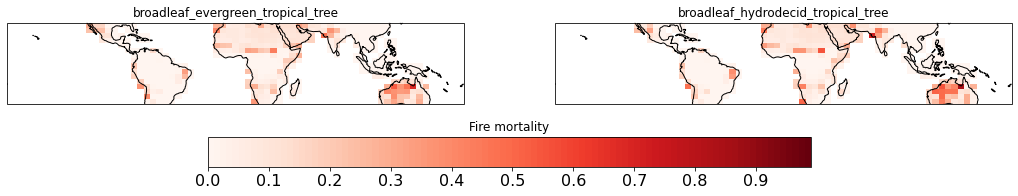

In [61]:
order = [0,2,4,1,3,5,6]
# Define the contour levels to use in plt.contourf
clevs=np.arange(0,1.0,0.01)
fig, axs = plt.subplots(nrows=1,ncols=2,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(18,4))
axs=axs.flatten()
for i in range(0,2):
        cs= fmort.isel(fates_levpft=i).plot(levels=clevs,cmap='Reds', ax=axs[i],add_colorbar=False)
        axs[i].set_title(pftnames[i])
        axs[i].coastlines()

cbar = fig.colorbar(cs, ax=axs, location='bottom',shrink=0.6)
cbar.ax.set_title("Fire mortality")
cbar.ax.tick_params(labelsize=16)


### LAI 

In [62]:
fates_lai = fates.FATES_LAI.mean(dim='time') * fates.FATES_FRACTION.mean(dim='time')

In [63]:
lai_ds =  '/pscratch/sd/j/jneedham/ILAMB/DATA/lai/MODIS/lai_0.5x0.5.nc'
lai_ds = xr.open_dataset(lai_ds, decode_times=False)

nyears = int(len(lai_ds.variables['time'])/12)
tstart = (nyears-10)*12
tstop  = nyears*12

lai = lai_ds.lai
lai = lai.mean(dim='time') 


/global/homes/j/jneedham/.conda/envs/myenv/lib/python3.9/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'lai' has multiple fill values {1e+36, -999.0}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


In [64]:
lai.coords

Coordinates:
  * lat      (lat) float32 -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
  * lon      (lon) float32 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8

In [65]:
# Cut to just the tropics
cropped_lai = lai.sel(lat=slice(-30,30))
# Regrid to 4x5 degree resolution
new_lon = np.linspace(cropped_lai.lon[0], cropped_lai.lon[-1], fates_lai.sizes['lon'])
new_lat = np.linspace(cropped_lai.lat[0], cropped_lai.lat[-1], fates_lai.sizes['lat'])
lai_regrid = cropped_lai.interp(lat=new_lat,lon=new_lon)


In [66]:
fates_lai = fates_lai.assign_coords(lon=(((fates_lai.lon + 180) % 360) - 180))
fates_lai = fates_lai.sortby(fates_lai.lon)

In [67]:
fates_lai = fates_lai.assign_coords({'lon':lai_regrid.coords['lon']})
fates_lai = fates_lai.assign_coords({'lat':lai_regrid.coords['lat']})

In [68]:
diff  = lai_regrid - fates_lai

''

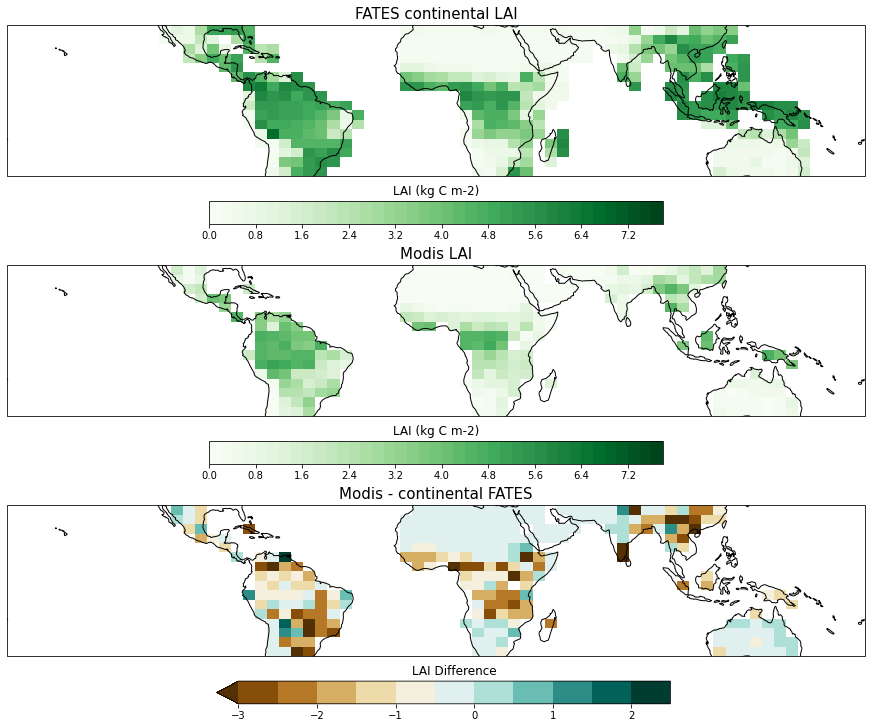

In [69]:
fig, axs = plt.subplots(nrows=3,ncols=1,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(18,10),constrained_layout=True)

clevs = np.arange(0.,8,0.2)
axs=axs.flatten()

cs = fates_lai.plot(levels=clevs, transform=ccrs.PlateCarree(),cmap='Greens',
         ax=axs[0], add_colorbar=False)
axs[0].coastlines()
axs[0].set_title('FATES continental LAI', fontsize=15)
cbar = fig.colorbar(cs, ax=axs[0], location='bottom',shrink=0.6)
cbar.ax.set_title("LAI (kg C m-2)")

cs = lai_regrid.plot(levels=clevs, transform=ccrs.PlateCarree(),cmap='Greens',
         ax=axs[1], add_colorbar=False)
axs[1].coastlines()
axs[1].set_title('Modis LAI', fontsize=15)
cbar = fig.colorbar(cs, ax=axs[1], location='bottom',shrink=0.6)
cbar.ax.set_title("LAI (kg C m-2)")

clevs = np.arange(-3,3,0.5)
cs = diff.plot(levels=clevs, transform=ccrs.PlateCarree(),cmap='BrBG',
         ax=axs[2], add_colorbar=False)
axs[2].coastlines()
axs[2].set_title('Modis - continental FATES', fontsize=15)
cbar = fig.colorbar(cs, ax=axs[2], location='bottom',shrink=0.6)
cbar.ax.set_title("LAI Difference")

;

In [70]:
leafc_pf = fates.FATES_LEAFC_PF.mean(dim='time')

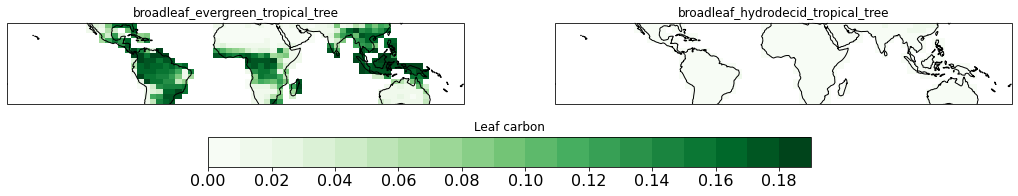

In [71]:
# Define the contour levels to use in plt.contourf
clevs=np.arange(0,0.2,0.01)
fig, axs = plt.subplots(nrows=1,ncols=2,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(18,4))
axs=axs.flatten()
for i in range(0,2):
        cs= leafc_pf.isel(fates_levpft=i).plot(levels=clevs,cmap='Greens', ax=axs[i],add_colorbar=False)
        axs[i].set_title(pftnames[i])
        axs[i].coastlines()

cbar = fig.colorbar(cs, ax=axs, location='bottom',shrink=0.6)
cbar.ax.set_title("Leaf carbon")
cbar.ax.tick_params(labelsize=16)


### Total crown area by pft

In [72]:
crownarea_pf = fates.FATES_CROWNAREA_PF.mean(dim='time')

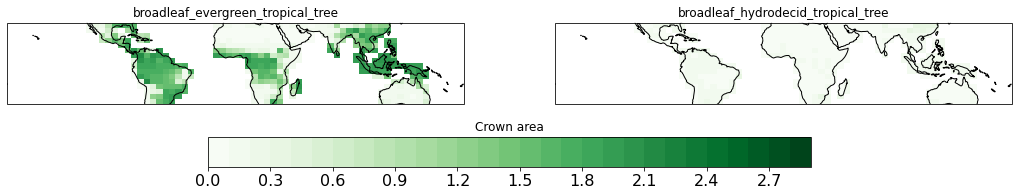

In [73]:
# Define the contour levels to use in plt.contourf
clevs=np.arange(0,3,0.1)
fig, axs = plt.subplots(nrows=1,ncols=2,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(18,4))
axs=axs.flatten()
for i in range(0,2):
        cs= crownarea_pf.isel(fates_levpft=i).plot(levels=clevs,cmap='Greens', ax=axs[i],add_colorbar=False)
        axs[i].set_title(pftnames[i])
        axs[i].coastlines()

cbar = fig.colorbar(cs, ax=axs, location='bottom',shrink=0.6)
cbar.ax.set_title("Crown area")
cbar.ax.tick_params(labelsize=16)


### canopy crown area by pft

In [74]:
canopy_crownarea_pf = fates.FATES_CANOPYCROWNAREA_PF.mean(dim='time')

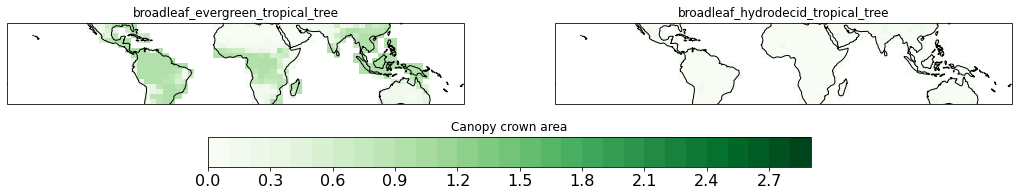

In [75]:
# Define the contour levels to use in plt.contourf
clevs=np.arange(0,3,0.1)
fig, axs = plt.subplots(nrows=1,ncols=2,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(18,4))
axs=axs.flatten()
for i in range(0,2):
        cs= canopy_crownarea_pf.isel(fates_levpft=i).plot(levels=clevs,cmap='Greens', ax=axs[i],add_colorbar=False)
        axs[i].set_title(pftnames[i])
        axs[i].coastlines()

cbar = fig.colorbar(cs, ax=axs, location='bottom',shrink=0.6)
cbar.ax.set_title("Canopy crown area")
cbar.ax.tick_params(labelsize=16)